In [95]:
import pandas as pd
import numpy as np
import sqlite3
import dowhy
import causallearn
import matplotlib.pyplot as plt
import networkx as nx

from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.GraphUtils import GraphUtils

from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.graph.Node import Node

from data import chembl_physicochemical_assays
from display_utils import view_pydot


In [85]:
pivoted = chembl_physicochemical_assays(min_raw_assay_measurements=100, verbose=True)

Began with 181535 rows, for 17943 assays and 25734 molecules.

Filtered to 61352 rows, for 136 assays and 5476 moleucles.

Name remapping brings these numbers to 1402 rows, for 25 assays.

description
Partition coefficient (logP)                                                                                                                                                         5843
ASTRAZENECA: Octan-1-ol/water (pH7.4) distribution coefficent measured  by a shake flask method described in J. Biomol. Screen. 2011, 16, 348-355. Experimental range -1.5 to 4.5    4200
Dissociation constant, pKa of the compound                                                                                                                                           3396
Lipophilicity, log P of the compound                                                                                                                                                 2850
Lipophilicity, log D of the compound at pH 7.4         

/Users/patrickrowe/Documents/Code/chembl-causal/data.py:189: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pivoted = pivoted.groupby(level=0, axis=1).mean()


In [88]:
# pivoted = pivoted.drop(columns=pivoted.columns.to_list())

# Weird; to investigate. Model eventually finds that "all things cause ethanol solubility"
# But this also MASSIVELY increases the time for the calculation to run. 
pivoted = pivoted.drop(columns=['Ethanol Solubility'])

## Okay, lets try naively inferring the causal relation on this more complex set of data using FCI.

In [89]:
cg, nodes = fci(pivoted.to_numpy(), node_names=pivoted.columns.to_list(), depth=-1, alpha=0.2)

  0%|          | 0/25 [00:00<?, ?it/s]

Solubility pH6.0 --> Solubility pH5.0
Solubility pH7.5 --> Solubility pH5.0
Solubility pH6.0 --> Solubility pH7.5
Solubility pH7.0 --> Solubility pH8.0


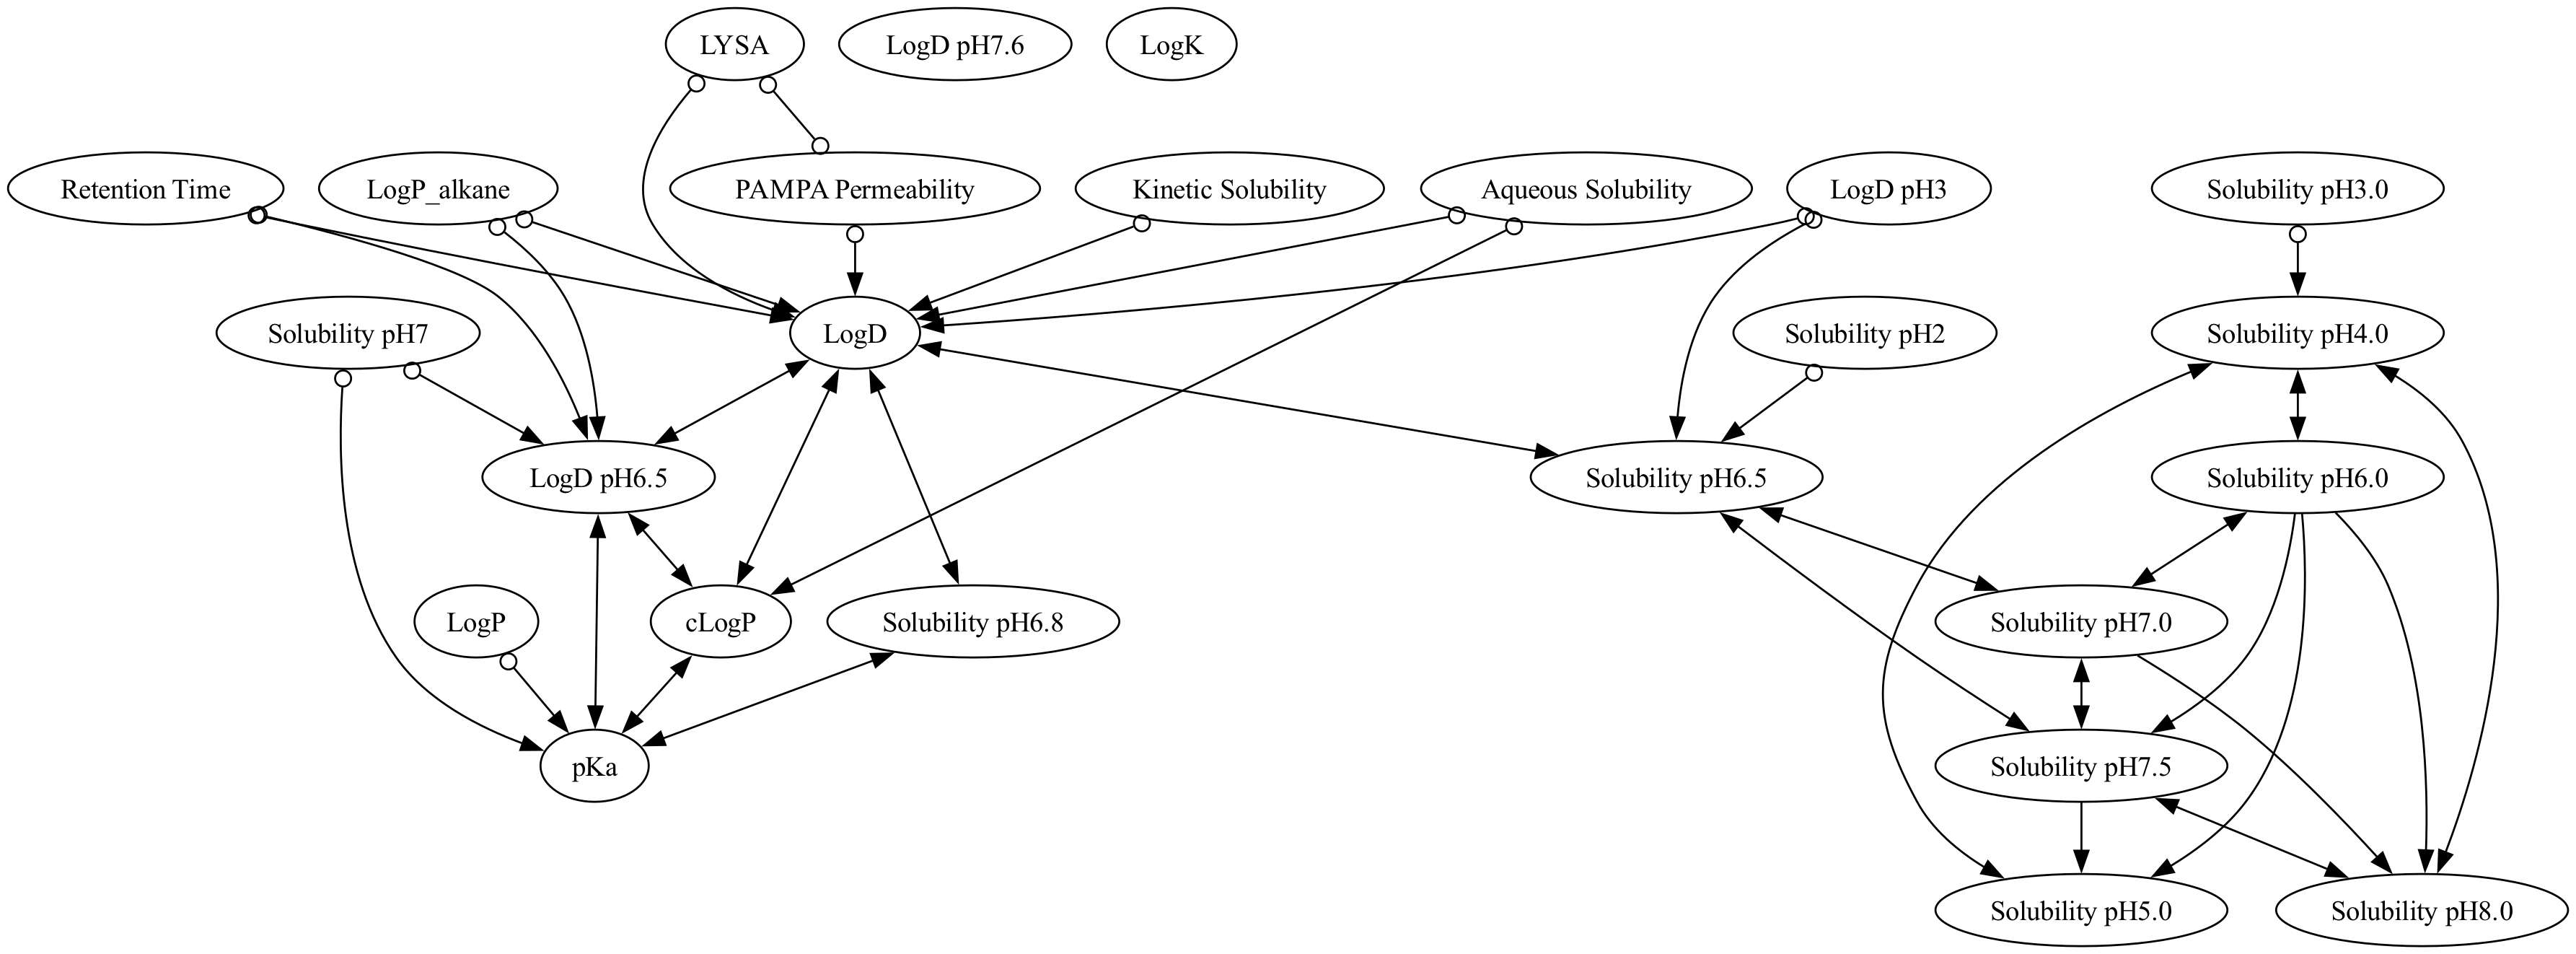

In [90]:
pydot_graph = GraphUtils.to_pydot(cg)
view_pydot(pydot_graph=pydot_graph)

## Fine, but PAMPA obviously doesn't _CAUSE_ LogD, nor does LYSA. So can we encode this prior knowledge directly

In [ ]:
# NICE!!!
prior_knowledge = BackgroundKnowledge()
prior_knowledge = prior_knowledge.add_required_by_pattern("LogD", "PAMPA Permeability")
prior_knowledge = prior_knowledge.add_required_by_pattern("LogD", "LYSA")

In [99]:
cg, nodes = fci(pivoted.to_numpy(), node_names=pivoted.columns.to_list(), depth=-1, alpha=0.2, background_knowledge=prior_knowledge)

  0%|          | 0/25 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): LogD --> LYSA
Orienting edge (Knowledge): LogD --> PAMPA Permeability
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): LogD --> LYSA
Orienting edge (Knowledge): LogD --> PAMPA Permeability
Finishing BK Orientation.
LogD --> LYSA
LogD --> PAMPA Permeability
Solubility pH6.0 --> Solubility pH5.0
Solubility pH7.5 --> Solubility pH5.0
Solubility pH6.0 --> Solubility pH7.5
Solubility pH7.0 --> Solubility pH8.0


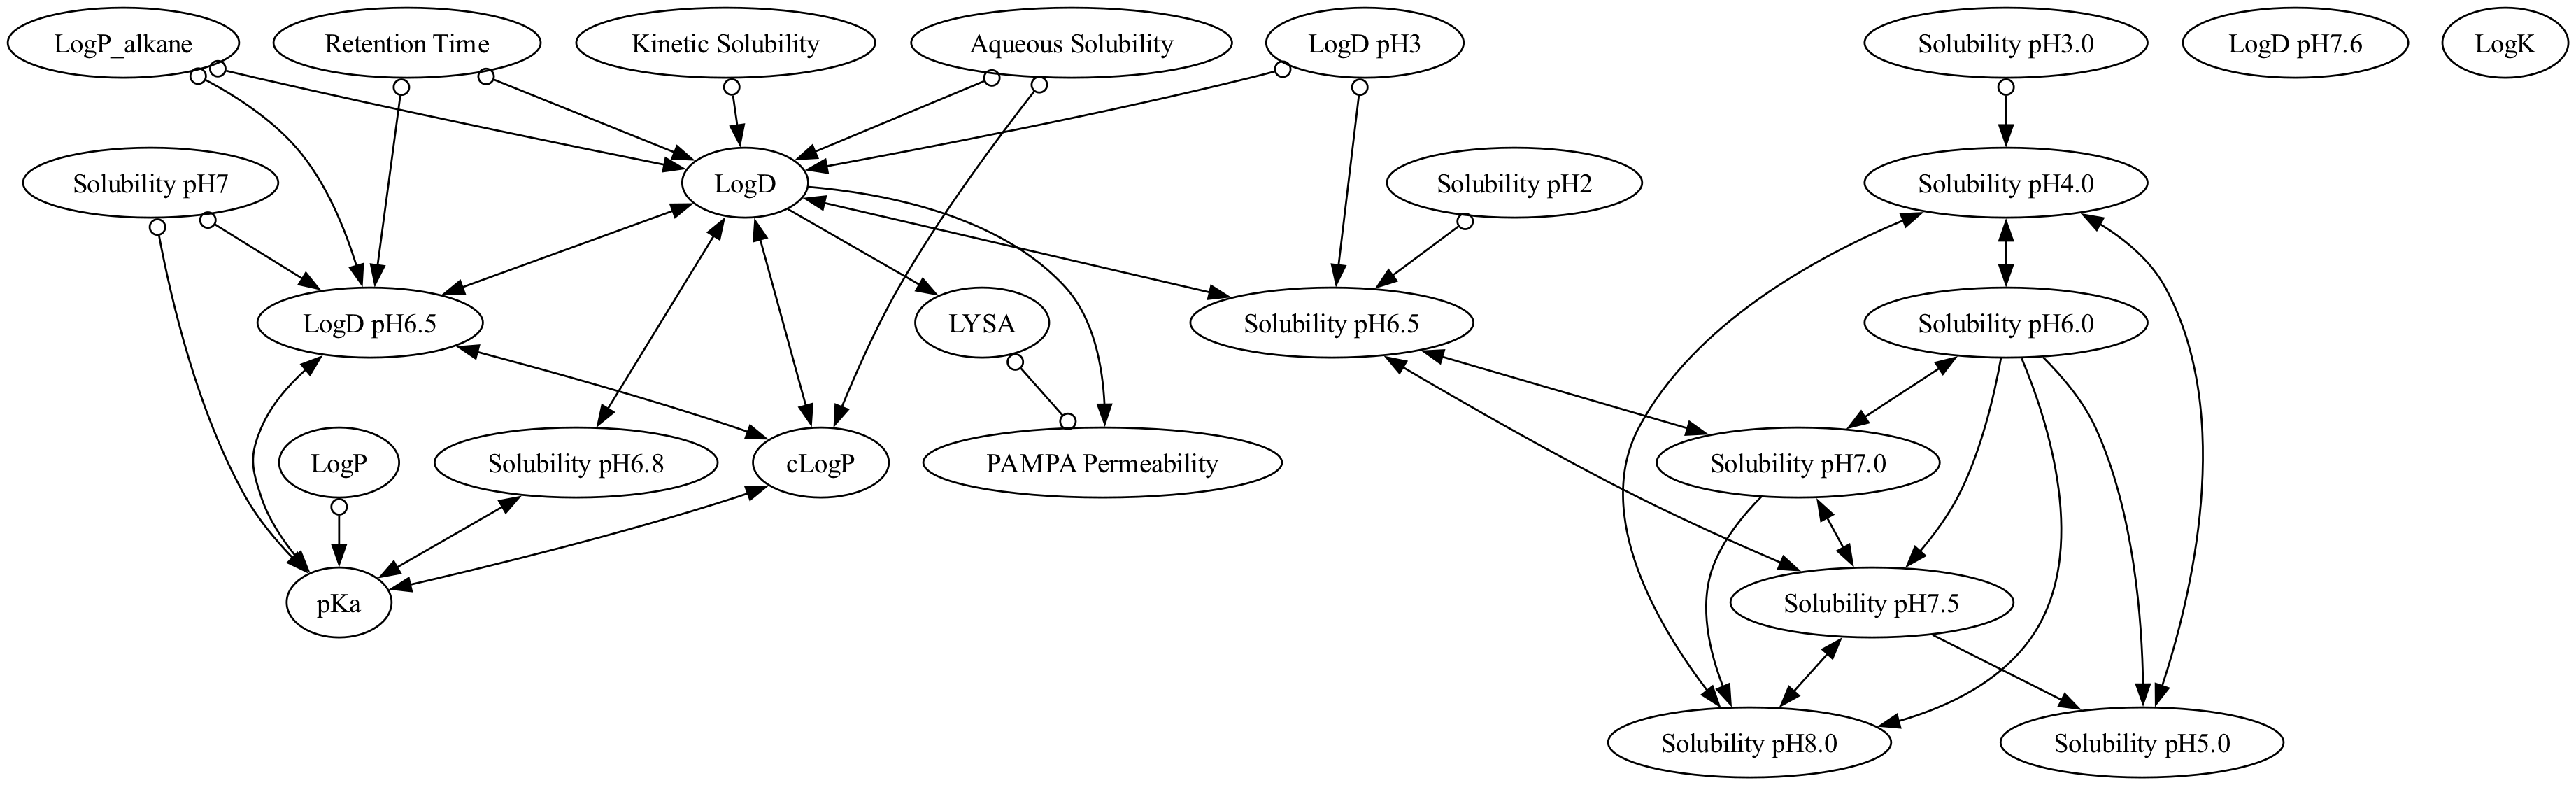

In [100]:
pydot_graph = GraphUtils.to_pydot(cg)
view_pydot(pydot_graph=pydot_graph)